In [1]:
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import mean_squared_error


# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Read the Dataset

In [2]:
import pandas as pd


GS = pd.read_csv('GS.csv')

GS

,Date,Open,High,Low,Close,Adj Close,Volume
0,2022-11-22,381.399994,385.829987,381.399994,383.869995,378.657684,2019400
1,2022-11-23,383.899994,388.200012,383.410004,386.250000,381.005371,1865400
2,2022-11-25,385.760010,389.440002,385.179993,388.859985,383.579926,1129300
3,2022-11-28,385.429993,388.390015,380.890015,382.359985,377.168152,2232200
4,2022-11-29,381.130005,384.929993,379.260010,383.709991,378.499847,1746900
...,...,...,...,...,...,...,...
96,2023-04-13,330.079987,332.940002,327.000000,332.130005,332.130005,1765500
97,2023-04-14,336.529999,339.630005,334.320007,336.920013,336.920013,2274400
98,2023-04-17,336.000000,340.450012,333.679993,339.679993,339.679993,3012100
99,2023-04-18,328.000000,336.549988,326.130005,333.910004,333.910004,7549500


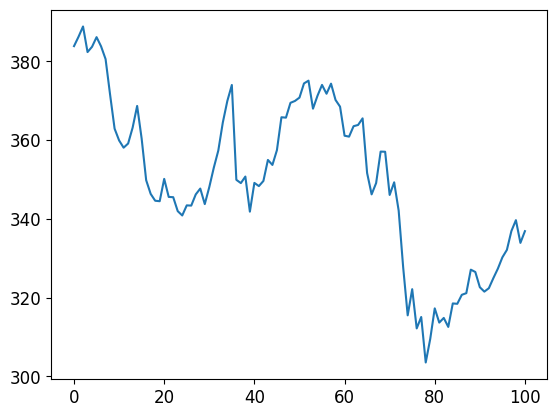

In [4]:
#Plot temp

plt.plot(GS['Close'])
plt.show()

In [7]:
row_count = GS.shape[0] # store the number of obersvations (daily temperature readings)
row_count

101

In [8]:
stocks = GS.to_numpy() # to make things easier, we create a numpy array from our dataframe of temperatures
stocks.shape

(101, 1)

In [9]:
sequence_length = 10  # here, I create a variable to hold the number of days that will be in a sequence. This makes it easier to change later.

In [10]:
stocks = stocks[row_count % sequence_length: ] # Since our data may not be a multiple of sequence_length, we will ignore 
# the first number of days in order to make the total a number divisible by sequence length
stocks.shape

(100, 1)

In [11]:
stocks.shape

(100, 1)

In [12]:
stocks = stocks.reshape(row_count //sequence_length,sequence_length) # note that temps are a multiple of sequence length, we can split the data into rows of sequence length.
stocks

array([[386.25    , 388.859985, 382.359985, 383.709991, 386.149994,
        383.809998, 380.579987, 371.540009, 362.910004, 359.920013],
       [358.079987, 359.140015, 363.179993, 368.690002, 360.380005,
        349.829987, 346.350006, 344.609985, 344.48999 , 350.160004],
       [345.579987, 345.51001 , 341.970001, 340.869995, 343.429993,
        343.380005, 346.220001, 347.700012, 343.76001 , 348.079987],
       [353.      , 357.359985, 364.480011, 369.940002, 374.      ,
        349.920013, 349.089996, 350.75    , 341.839996, 349.140015],
       [348.329987, 349.630005, 354.970001, 353.700012, 357.459991,
        365.809998, 365.709991, 369.470001, 369.950012, 370.799988],
       [374.399994, 375.100006, 367.98999 , 371.279999, 374.019989,
        371.779999, 374.339996, 370.200012, 368.5     , 361.119995],
       [360.890015, 363.540009, 363.850006, 365.529999, 351.649994,
        346.230011, 349.100006, 357.089996, 357.049988, 346.079987],
       [349.290009, 342.089996, 327.67001

In [13]:
# we can now see that our days have been organized into rows of sequence length. 

In [14]:
# create our X and y. 
# X will be the 9 days prior...
X = stocks[:, :-1] # all rows, all columns except the last one
# y will be the 10th day (what we are trying to predict)
y = stocks[:, -1] # all rows, only the last column

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [16]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print(X_train.shape)
print(X_test.shape)

(7, 9, 1)
(3, 9, 1)


In [17]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, SimpleRNN, GRU, Conv1D

n_steps = sequence_length - 1
n_inputs = 1

model = Sequential(
    [
        SimpleRNN(64, input_shape=[n_steps, n_inputs]),
        Dense(1, activation=None)
    ]
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 64)                4224      
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 4,289
Trainable params: 4,289
Non-trainable params: 0
_________________________________________________________________


In [18]:
# If multiclass, use "sparse_categorical_crossentropy" as the loss function
model.compile(
    loss="mean_squared_error", 
    optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001), 
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

In [19]:
from tensorflow.keras.callbacks import EarlyStopping

import time
start_time = time.time()

early_stop = EarlyStopping(monitor='val_root_mean_squared_error', min_delta = 0.0, patience=10, verbose=1, mode='min')

history = model.fit(
    X_train, 
    y_train, 
    epochs=600,
    validation_data=(X_test, y_test), 
    callbacks=[early_stop]
)

end_time = time.time()

Epoch 1/600
1/1 [==============================] - 3s 3s/step - loss: 120533.2500 - root_mean_squared_error: 347.1790 - val_loss: 118971.9609 - val_root_mean_squared_error: 344.9231
Epoch 2/600
1/1 [==============================] - 0s 46ms/step - loss: 120505.7891 - root_mean_squared_error: 347.1394 - val_loss: 118944.5312 - val_root_mean_squared_error: 344.8834
Epoch 3/600
1/1 [==============================] - 0s 43ms/step - loss: 120478.1875 - root_mean_squared_error: 347.0997 - val_loss: 118915.7891 - val_root_mean_squared_error: 344.8417
Epoch 4/600
1/1 [==============================] - 0s 47ms/step - loss: 120449.2500 - root_mean_squared_error: 347.0580 - val_loss: 118885.6250 - val_root_mean_squared_error: 344.7979
Epoch 5/600
1/1 [==============================] - 0s 44ms/step - loss: 120418.8750 - root_mean_squared_error: 347.0142 - val_loss: 118853.6875 - val_root_mean_squared_error: 344.7516
Epoch 6/600
1/1 [==============================] - 0s 42ms/step - loss: 120386.710

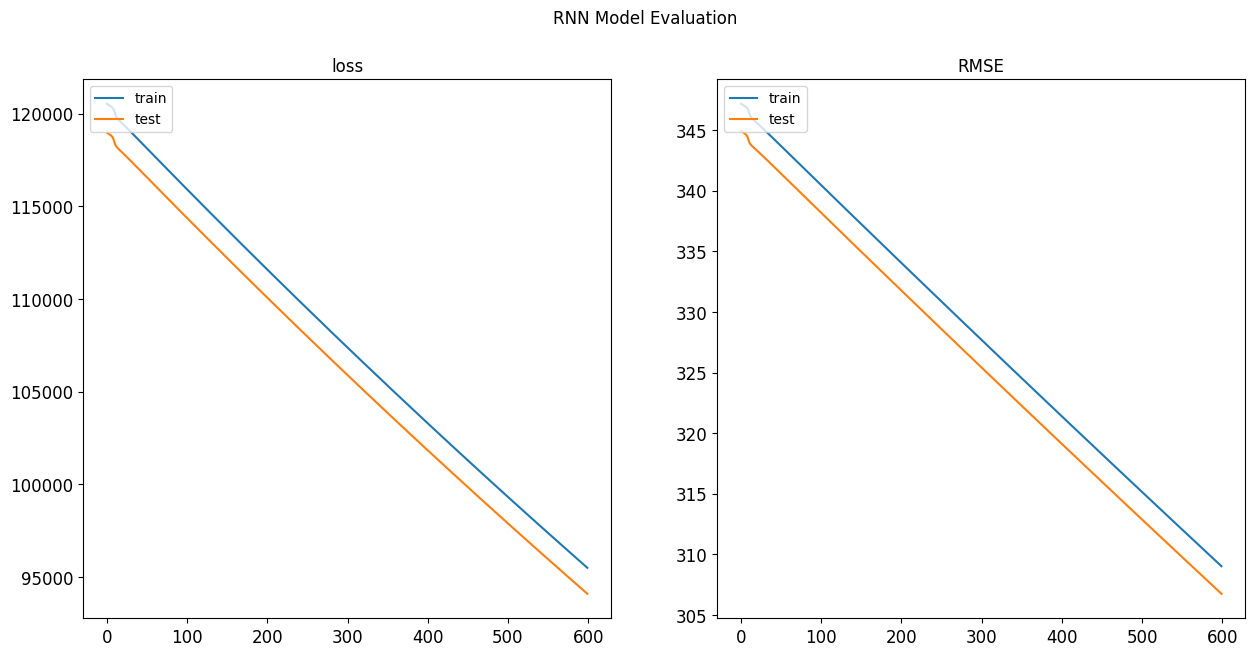

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
fig.suptitle('RNN Model Evaluation')

ax1.set_title('loss')
#ax1.set_ylim(0, 100)
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.legend(['train', 'test'], loc='upper left')

ax2.set_title('RMSE')
#ax2.set_ylim(0, 1)
ax2.plot(history.history['root_mean_squared_error'])
ax2.plot(history.history['val_root_mean_squared_error'])
ax2.legend(['train', 'test'], loc='upper left')

In [21]:
from sklearn.metrics import mean_squared_error

y_pred = model.predict(X_test)  # these predictions are probabilities (0-1) taken from the sigmoid function

mean_squared_error(y_test, y_pred)**0.5


1/1 [==============================] - 0s 233ms/step


306.74068160990396

Now, let's say our past 9 days of temperatures were as follow....

In [22]:
prior_days = np.array(
    [ 383.869995,385.25,378.859985,382.359985,384.709991,386.149994,383.809998,379.579987,371.540009 ]
)

# reshape into the three dimensions for input into model
prior_days = prior_days.reshape(1, 9, 1) # 1 row, 59 time steps (features), and 1 output/prediction)

In [23]:
model.predict(prior_days) # note the structure of the prediction

1/1 [==============================] - 0s 28ms/step


array([[38.329823]], dtype=float32)

In [24]:
tomorrows_temp = model.predict(prior_days)[0][0] # we see the predicted temp is embedded inside two dimensions

1/1 [==============================] - 0s 26ms/step


In [79]:
print(f"Tomorrow's predicted stock price is {tomorrows_temp:.2f}.")

Tomorrow's predicted stock price is 407.60.


In [26]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, SimpleRNN, GRU, Conv1D

n_steps = sequence_length - 1
n_inputs = 1

model = Sequential(
    [
        SimpleRNN(64, input_shape=[n_steps, n_inputs]),
        Dense(1, activation=None)
    ]
)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 64)                4224      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,289
Trainable params: 4,289
Non-trainable params: 0
_________________________________________________________________


In [27]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(64, activation='relu', return_sequences=True, input_shape=[n_steps, n_inputs]),
    keras.layers.SimpleRNN(64, activation='relu', return_sequences=False),
    keras.layers.Dense(1, activation=None)
])

In [28]:
np.random.seed(42)
tf.random.set_seed(42)

model.compile(loss="mse", optimizer='Adam')

history = model.fit(X_train, y_train, epochs=30)

Epoch 1/30
1/1 [==============================] - 2s 2s/step - loss: 303071.5938
Epoch 2/30
1/1 [==============================] - 0s 8ms/step - loss: 239745.2969
Epoch 3/30
1/1 [==============================] - 0s 10ms/step - loss: 194320.1406
Epoch 4/30
1/1 [==============================] - 0s 10ms/step - loss: 158899.0469
Epoch 5/30
1/1 [==============================] - 0s 9ms/step - loss: 132233.2188
Epoch 6/30
1/1 [==============================] - 0s 9ms/step - loss: 110301.7266
Epoch 7/30
1/1 [==============================] - 0s 9ms/step - loss: 95988.8047
Epoch 8/30
1/1 [==============================] - 0s 9ms/step - loss: 87825.6016
Epoch 9/30
1/1 [==============================] - 0s 9ms/step - loss: 77677.5859
Epoch 10/30
1/1 [==============================] - 0s 9ms/step - loss: 67433.0781
Epoch 11/30
1/1 [==============================] - 0s 10ms/step - loss: 57316.9805
Epoch 12/30
1/1 [==============================] - 0s 11ms/step - loss: 47172.3516
Epoch 13/30
1/1 

### Predictions

In [29]:

y_pred = model.predict(X_test)  # these predictions are probabilities (0-1) taken from the sigmoid function

mean_squared_error(y_test, y_pred)**0.5


1/1 [==============================] - 0s 320ms/step


32.7212689446225

In [30]:
prior_days1 = np.array(
    [ 383.869995,386.25,388.859985,382.359985,383.709991,386.149994,383.809998,380.579987,371.540009 ]
)

# reshape into the three dimensions for input into model
prior_days1 = prior_days1.reshape(1, 9, 1) # 1 row, 59 time steps (features), and 1 output/prediction)

In [31]:
model.predict(prior_days1) # note the structure of the prediction

1/1 [==============================] - 0s 26ms/step


array([[341.5145]], dtype=float32)

In [32]:
tomorrows_temp = model.predict(prior_days1)[0][0] # we see the predicted temp is embedded inside two dimensions

1/1 [==============================] - 0s 26ms/step


In [33]:
print(f"Tomorrow's predicted stock close is {tomorrows_temp:.2f} ")

Tomorrow's predicted stock close is 341.51 


In [34]:

start_time = time.time()

early_stop = EarlyStopping( min_delta = 0.0, patience=10, verbose=1, mode='min')

history = model.fit(
    X_train, 
    y_train, 
    epochs=600,
    validation_data=(X_test, y_test), 
    callbacks=[early_stop]
)

end_time = time.time()

Epoch 1/600
1/1 [==============================] - 0s 409ms/step - loss: 1214.3917 - val_loss: 1631.0089
Epoch 2/600
1/1 [==============================] - 0s 41ms/step - loss: 1798.8855 - val_loss: 2076.1423
Epoch 3/600
1/1 [==============================] - 0s 41ms/step - loss: 2255.7720 - val_loss: 2297.8010
Epoch 4/600
1/1 [==============================] - 0s 42ms/step - loss: 2484.1780 - val_loss: 2273.7478
Epoch 5/600
1/1 [==============================] - 0s 43ms/step - loss: 2461.1526 - val_loss: 2047.9113
Epoch 6/600
1/1 [==============================] - 0s 45ms/step - loss: 2223.1794 - val_loss: 1661.0898
Epoch 7/600
1/1 [==============================] - 0s 44ms/step - loss: 1823.7291 - val_loss: 1184.1753
Epoch 8/600
1/1 [==============================] - 0s 50ms/step - loss: 1329.1185 - val_loss: 736.5952
Epoch 9/600
1/1 [==============================] - 0s 45ms/step - loss: 853.7835 - val_loss: 372.9408
Epoch 10/600
1/1 [==============================] - 0s 42ms/step -

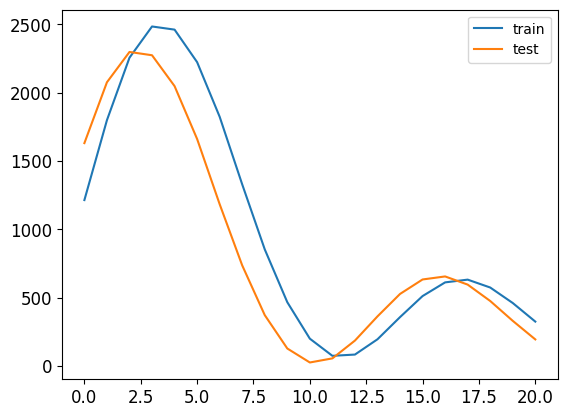

In [35]:

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.legend(['train', 'test'], loc='upper right')


plt.show()

# LSTM with one layer

In [36]:
model = keras.models.Sequential([
    keras.layers.LSTM(32, activation='relu', input_shape=[n_steps, n_inputs]),
    keras.layers.Dense(1, activation=None)
])

In [37]:
np.random.seed(42)
tf.random.set_seed(42)

model.compile(loss="mean_squared_error", optimizer='Adam')
early_stop = EarlyStopping( min_delta = 0.0, patience=10, verbose=1, mode='min')

history = model.fit(X_train, y_train, epochs=30,
    validation_data=(X_test, y_test), 
    callbacks=[early_stop])

Epoch 1/30
1/1 [==============================] - 2s 2s/step - loss: 202575.1719 - val_loss: 193153.7500
Epoch 2/30
1/1 [==============================] - 0s 33ms/step - loss: 185310.3594 - val_loss: 176579.4375
Epoch 3/30
1/1 [==============================] - 0s 33ms/step - loss: 192271.7969 - val_loss: 117440.0938
Epoch 4/30
1/1 [==============================] - 0s 33ms/step - loss: 177904.7188 - val_loss: 300104.5312
Epoch 5/30
1/1 [==============================] - 0s 33ms/step - loss: 252603.8438 - val_loss: 189691.5781
Epoch 6/30
1/1 [==============================] - 0s 32ms/step - loss: 289521.5625 - val_loss: 228676.1875
Epoch 7/30
1/1 [==============================] - 0s 34ms/step - loss: 260912.6250 - val_loss: 236307.9219
Epoch 8/30
1/1 [==============================] - 0s 36ms/step - loss: 231998.6094 - val_loss: 251183.7500
Epoch 9/30
1/1 [==============================] - 0s 34ms/step - loss: 243523.2656 - val_loss: 225379.1875
Epoch 10/30
1/1 [======================

### Predictions

In [38]:
#Predict:
y_pred = model.predict(X_test)


1/1 [==============================] - 0s 166ms/step


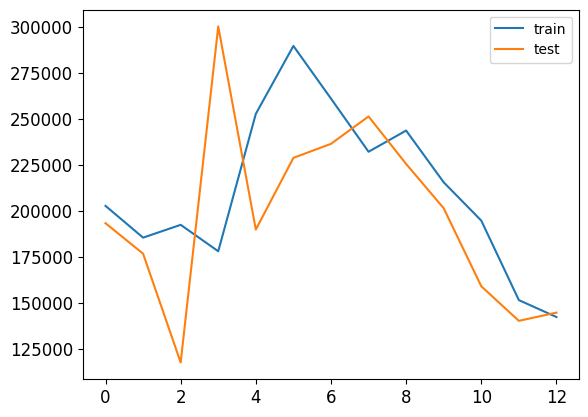

In [39]:

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.legend(['train', 'test'], loc='upper right')


plt.show()

In [80]:

y_pred = model.predict(X_test)  # these predictions are probabilities (0-1) taken from the sigmoid function

mean_squared_error(y_test, y_pred)**0.5


1/1 [==============================] - 0s 23ms/step


27.4027801094376

In [81]:
prior_days2 = np.array(
    [ 383.869995,386.25,388.859985,382.359985,383.709991,386.149994,383.809998,380.579987,371.540009 ]
)

# reshape into the three dimensions for input into model
prior_days2 = prior_days2.reshape(1, 9, 1) # 1 row, 59 time steps (features), and 1 output/prediction)

In [82]:
model.predict(prior_days2) # note the structure of the prediction

1/1 [==============================] - 0s 20ms/step


array([[407.59747]], dtype=float32)

In [83]:
tomorrows_temp = model.predict(prior_days2)[0][0] # we see the predicted temp is embedded inside two dimensions

1/1 [==============================] - 0s 32ms/step


In [84]:
print(f"Tomorrow's predicted stock close is {tomorrows_temp:.2f} ")

Tomorrow's predicted stock close is 407.60 


# LSTM with more layers

In [45]:
model = keras.models.Sequential([
    keras.layers.LSTM(64, activation='relu', return_sequences=True, input_shape=[n_steps, n_inputs]),
    keras.layers.LSTM(64, activation='relu', return_sequences=False),
    keras.layers.Dense(1, activation=None)
])

In [46]:
np.random.seed(42)
tf.random.set_seed(42)

model.compile(loss="mse", optimizer='Adam')

history = model.fit(X_train, y_train, epochs=50,validation_data=(X_test, y_test), 
    callbacks=[early_stop])

Epoch 1/50
1/1 [==============================] - 3s 3s/step - loss: 97826.4297 - val_loss: 107189.1641
Epoch 2/50
1/1 [==============================] - 0s 67ms/step - loss: 108869.4375 - val_loss: 79739.7891
Epoch 3/50
1/1 [==============================] - 0s 73ms/step - loss: 80221.6094 - val_loss: 70735.0156
Epoch 4/50
1/1 [==============================] - 0s 66ms/step - loss: 74013.4609 - val_loss: 64239.6445
Epoch 5/50
1/1 [==============================] - 0s 72ms/step - loss: 69100.5234 - val_loss: 59102.6250
Epoch 6/50
1/1 [==============================] - 0s 73ms/step - loss: 60434.8555 - val_loss: 48297.4688
Epoch 7/50
1/1 [==============================] - 0s 74ms/step - loss: 49648.5938 - val_loss: 42794.8164
Epoch 8/50
1/1 [==============================] - 0s 59ms/step - loss: 45228.6172 - val_loss: 43814.2344
Epoch 9/50
1/1 [==============================] - 0s 63ms/step - loss: 44307.1797 - val_loss: 40081.5117
Epoch 10/50
1/1 [==============================] - 0s 5

### Predictions

In [47]:
#Predict:
y_pred = model.predict(X_test)

1/1 [==============================] - 0s 358ms/step


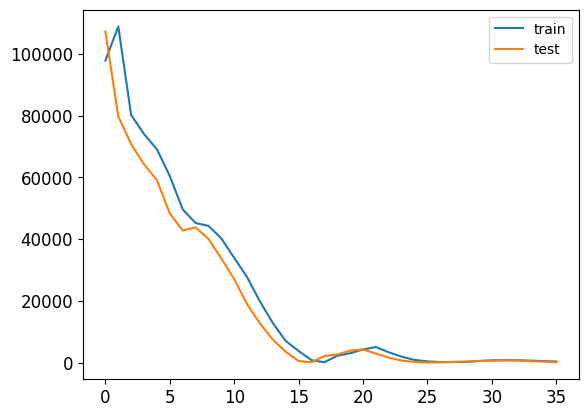

In [48]:

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.legend(['train', 'test'], loc='upper right')


plt.show()

In [49]:


mean_squared_error(y_test, y_pred)**0.5


12.966021723979999

In [50]:
prior_days3 = np.array(
    [ 383.869995,385.25,378.859985,382.359985,383.709991,386.149994,383.809998,379.579987,371.540009 ]
)

# reshape into the three dimensions for input into model
prior_days3 = prior_days3.reshape(1, 9, 1) # 1 row, 59 time steps (features), and 1 output/prediction)

In [51]:
model.predict(prior_days3) # note the structure of the prediction

1/1 [==============================] - 0s 28ms/step


array([[374.10727]], dtype=float32)

In [52]:
tomorrows_temp = model.predict(prior_days3)[0][0] # we see the predicted temp is embedded inside two dimensions

1/1 [==============================] - 0s 26ms/step


In [53]:
print(f"Tomorrow's predicted stock close is {tomorrows_temp:.2f} ")

Tomorrow's predicted stock close is 374.11 
